In [1]:
# Install packages
!pip install torch torchvision torchaudio --upgrade
!pip install pennylane cotengra quimb torchmetrics --upgrade
#!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [2]:
# Import packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from sklearn import datasets
import seaborn as sns
#import jax
import time

import functools

from typing import List, Union, Tuple, Dict, Optional, Any
from typing import Callable

#jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)
#import jax.numpy as jnp

#import optax  # optimization using jax

import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
#torch.set_printoptions(profile="full")
#import torch_xla
#import torch_xla.core.xla_model as xm



#import pennylane as qml
#import pennylane.numpy as pnp

import os, cv2, itertools # cv2 -- OpenCV
import shutil
import zipfile
%matplotlib inline

#from jax.lib import xla_bridge


sns.set()

seed = 1701
rng = np.random.default_rng(seed=seed)
#prng = pnp.random.default_rng(seed=seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

#torch.set_default_dtype(torch.double)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

COMPLEX_DTYPE = torch.cfloat #torch.cdouble
REAL_DTYPE = torch.float

print(device)

cuda


# Load the data

In [3]:
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Pad(2),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Lambda(lambda x: torch.squeeze(x)),
    #torchvision.transforms.Lambda(lambda x: x / torch.trace(x)),
    #torchvision.transforms.Lambda(lambda x: (x+torch.t(x))/2)
    torchvision.transforms.Normalize((0.5,), (0.5,)),
    torchvision.transforms.Lambda(lambda x: x.type(COMPLEX_DTYPE))
])

train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=True,
    transform=preprocess,
)
test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=True,
    transform=preprocess,
)
dummy_trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True
)
dummy_testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=True
)

dummy_x, dummy_y = next(iter(dummy_trainloader))

print(dummy_x.shape)  # 64x32x32
print(dummy_y.shape)  # 64
print(dummy_y)
print(dummy_x[0,0,16])

torch.Size([32, 1, 32, 32])
torch.Size([32])
tensor([7, 7, 5, 7, 4, 7, 7, 7, 5, 4, 7, 2, 7, 8, 1, 1, 1, 6, 4, 1, 5, 1, 2, 7,
        8, 0, 8, 6, 1, 8, 8, 7])
tensor([-1.0000+0.j, -1.0000+0.j, -1.0000+0.j, -1.0000+0.j, -1.0000+0.j, -1.0000+0.j,
        -1.0000+0.j, -1.0000+0.j, -1.0000+0.j, -1.0000+0.j, -1.0000+0.j, -1.0000+0.j,
        -1.0000+0.j, -1.0000+0.j, -1.0000+0.j, -1.0000+0.j, -1.0000+0.j, -1.0000+0.j,
        -1.0000+0.j,  0.2863+0.j,  0.7098+0.j, -0.7333+0.j, -1.0000+0.j, -1.0000+0.j,
        -1.0000+0.j, -1.0000+0.j, -1.0000+0.j, -1.0000+0.j, -1.0000+0.j, -1.0000+0.j,
        -1.0000+0.j, -1.0000+0.j])


# Some Utilities

In [4]:
ket = {
    '0':torch.tensor([1.,0.], dtype = COMPLEX_DTYPE, device=device),
    '1':torch.tensor([0.,1.], dtype = COMPLEX_DTYPE, device=device),
    '+':(torch.tensor([1,0], dtype = COMPLEX_DTYPE, device=device) + torch.tensor([0,1], dtype = COMPLEX_DTYPE, device=device))/torch.sqrt(torch.tensor(2, dtype = COMPLEX_DTYPE, device=device)),
    '-':(torch.tensor([1,0], dtype = COMPLEX_DTYPE, device=device) - torch.tensor([0,1], dtype = COMPLEX_DTYPE, device=device))/torch.sqrt(torch.tensor(2, dtype = COMPLEX_DTYPE, device=device))
}

pauli = {
    'I':torch.tensor([[1.,0.],[0.,1.]], dtype = COMPLEX_DTYPE, device=device),
    'X':torch.tensor([[0.,1.],[1.,0.]], dtype = COMPLEX_DTYPE, device=device),
    'Y':torch.tensor([[0., -1.j],[1.j, 0]], dtype = COMPLEX_DTYPE, device=device),
    'Z':torch.tensor([[1.,0.],[0.,-1.]], dtype = COMPLEX_DTYPE, device=device)
}

def tensor_product(*args):
  input_list = [a for a in args]
  return functools.reduce(torch.kron, input_list)

def multi_qubit_identity(n_qubits:int):
  assert n_qubits>0
  if n_qubits == 1:
    return pauli['I']
  else:
    return tensor_product(*[pauli['I'] for _ in range(n_qubits)])

pauli_words_su4 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    if not (key1==key2 and key1=='I' and key2=='I'):
      #print(key1, key2)
      #print(pauli[key1])
      #print(pauli[key2])
      pauli_words_su4[key1+key2] = tensor_product(pauli[key1], pauli[key2])
      #print(pauli_words_su4[key1+key2])

pauli_words_su8 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      if not key1+key2+key3 == 'III':
        pauli_words_su8[key1+key2+key3] = tensor_product(pauli[key1], pauli[key2], pauli[key3])

pauli_words_su16 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      for key4 in pauli.keys():
        if not key1+key2+key3+key4 == 'IIII':
          pauli_words_su16[key1+key2+key3+key4] = tensor_product(
              pauli[key1],
              pauli[key2],
              pauli[key3],
              pauli[key4]
          )

pauli_words_su32 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      for key4 in pauli.keys():
        for key5 in pauli.keys():
          if not key1+key2+key3+key4+key5 == 'IIIII':
            pauli_words_su32[key1+key2+key3+key4+key5] = tensor_product(
                pauli[key1],
                pauli[key2],
                pauli[key3],
                pauli[key4],
                pauli[key5]
            )

def su32_op(
    params
):
  dict_values = list(pauli_words_su32.values())
  generator = torch.einsum("i,ijk->jk", params, torch.stack(dict_values))
  #print(generator.shape)
  return torch.matrix_exp(1j*generator)

def su4_op(
    params
):
  dict_values = torch.stack(list(pauli_words_su4.values()))
  #print(dict_values.shape)
  generator = torch.einsum("i, ijk -> jk", params, dict_values)
  return torch.linalg.matrix_exp(1.0j*generator)

def pauli_dict_func(key):
    return pauli[key]

def pauli_dict_func_multiple_keys(keys):
    return list(map(pauli_dict_func, keys))

def pauli_string_tensor_prod(pauli_string:str):
    paulis_char = list(pauli_string)
    paulis_mat = pauli_dict_func_multiple_keys(paulis_char)
    return tensor_product(*paulis_mat)

def generate_nqubit_pauli_strings(n_qubits:int):
    assert n_qubits>0
    pauli_labels = ['I', 'X', 'Y', 'Z']
    pauli_strings = []
    for labels in itertools.product(pauli_labels, repeat=n_qubits):
        pauli_str = "".join(labels)
        if pauli_str != 'I'*n_qubits:
            pauli_strings.append(pauli_str)
    return pauli_strings

def generate_pauli_tensor_list(pauli_strings:list):
    return list(map(pauli_string_tensor_prod, pauli_strings))


print(
    generate_pauli_tensor_list(generate_nqubit_pauli_strings(2))
)


#test_params = torch.randn(4**2-1,  device=device).type(COMPLEX_DTYPE)
#print(test_params.shape)
#test_op = su4_op(test_params)
#print(test_op)
#print(qml.is_unitary(qml.QubitUnitary(test_op.cpu().numpy(), wires=[0,1]))) # will be false if not torch.cdouble

#rx = torch.linalg.matrix_exp(1j*torch.pi*pauli["X"]/2)
#print(qml.is_unitary(qml.QubitUnitary(rx.cpu().numpy(), wires=[0])))

[tensor([[0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]], device='cuda:0'), tensor([[0.+0.j, 0.-1.j, 0.+0.j, 0.-0.j],
        [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.-0.j, 0.+0.j, 0.-1.j],
        [0.+0.j, 0.+0.j, 0.+1.j, 0.+0.j]], device='cuda:0'), tensor([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
        [ 0.+0.j, -1.+0.j,  0.+0.j, -0.+0.j],
        [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
        [ 0.+0.j, -0.+0.j,  0.+0.j, -1.+0.j]], device='cuda:0'), tensor([[0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
        [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]], device='cuda:0'), tensor([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
        [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
        [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]], device='cuda:0'), tensor([[0.+0.j, 0.-0.j, 0.+0.j, 0.-1.j],
      

In [5]:
def measure_sv(
    state,
    observable
    ):
  """
  Measure a statevector with a Hermitian observable.
  Note: No checking Hermitianicity of the observable or whether the observable
  has all real eigenvalues or not
  """
  expectation_value = torch.conj(state)@observable@state
  return torch.real(expectation_value)

def measure_dm(
    rho,
    observable
):
  """
  Measure a density matrix with a Hermitian observable.
  Note: No checking Hermitianicity of the observable or whether the observable
  has all real eigenvalues or not.
  """
  product = torch.matmul(rho, observable)

  # Calculate the trace, which is the sum of diagonal elements
  trace = torch.trace(product)

  # The expectation value should be real for physical observables
  return torch.real(trace)

vmap_measure_sv = torch.vmap(measure_sv, in_dims=(None, 0), out_dims=0)
vmap_measure_dm = torch.vmap(measure_dm, in_dims=(None, 0), out_dims=0)

# assuming the input patch observables (hermitianized) has shape (batchsize,n_patches, c, h, w)
# assuming the input set statevectors has shape (c, 2**n)
# output should have the shape (batchsize,n_patches, channel)
vmap_measure_channel_sv_batched_ob = torch.vmap(measure_sv, in_dims = (-2, -3),out_dims=-1)


# assuming the input set desnity matrices has shape (batchsize, n_patches, c, 2**n, 2**n)
# output should have the shape (batchsize,n_patches, channel)
vmap_measure_channel_dm_batched_ob = torch.vmap(measure_dm, in_dims = (-2, -3),out_dims=-1)


def bitstring_to_state(bitstring:str):
  """
  Convert a bit string, like '0101001' or '+-+-101'
  to a statevector. Each character in the bitstring must be among
  0, 1, + and -
  """
  assert len(bitstring)>0
  for c in bitstring:
    assert c in ['0', '1', '+', '-']
  single_qubit_states = [ket[c] for c in bitstring]
  return tensor_product(*single_qubit_states)


#test_patch = torch.randn(size=[5, 2, 3, 4,4], dtype = torch.double, device=device).type(torch.cdouble)
#test_herm_patch = (torch.einsum("...jk->...kj", test_patch)+test_patch)/2
#print(test_herm_patch)
#print("all patches shape", test_herm_patch.shape)
#test_sv = torch.stack([bitstring_to_state('++')]*3, axis = 0)
#print(test_sv)
#print("all sv shape", test_sv.shape)
#res = vmap_measure_channel_sv_batched_ob(test_sv, test_herm_patch)
#print(res)
#print("res shape",res.shape)

#for batchid in range(test_patch.shape[0]):
#  batchitem = test_patch[batchid]
#  for patch_idx in range(batchitem.shape[0]):
#    patch = batchitem[patch_idx]
#    for ch_idx in range(patch.shape[0]):
#      print(f"batchid={batchid}; patchid = {patch_idx}; chid = {ch_idx}")
#      ch = patch[ch_idx]
#      #print(ch.shape)
#      sv_ch = test_sv[ch_idx]
#      #print(sv_ch.shape)
#      print(measure_sv(sv_ch, ch))


# Flipped Quanvolution Kernel

First, let's define the function to extract patches for a single kernel.

In [6]:
def extract_patches(image, patch_size, stride, padding=None):
    """
    Extracts patches from an image with multiple input channels and optional custom padding.

    Args:
        image (torch.Tensor): Input image tensor of shape (in_channels, height, width).
        patch_size (int): Size of the square patches to extract.
        stride (int): Stride between patches.
        padding (tuple): Padding value(s) for each dimension.

    Returns:
        torch.Tensor: Tensor of extracted patches of shape (num_patches, in_channels, patch_size, patch_size).
    """
    in_channels, height, width = image.shape[-3], image.shape[-2], image.shape[-1]
    pad_l, pad_r, pad_t, pad_b = padding if padding is not None else (0,0,0,0)

    if padding is not None:
        image = torch.nn.functional.pad(image, (pad_l, pad_r, pad_t, pad_b), mode='constant')
    else:
        image = image

    height, width = image.shape[-2],  image.shape[-1]
    num_patches_h = (height - patch_size) // stride + 1
    num_patches_w = (width - patch_size) // stride + 1

    patches = []
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            patch = image[..., i*stride:i*stride+patch_size, j*stride:j*stride+patch_size]
            patches.append(patch)

    patches = torch.stack(patches, dim=-4)
    return patches # has shape (batchsize, n_patches, channel, h, w)


#single_img = torch.stack([torch.arange(32*32*1,dtype = torch.double, device=device).reshape((32,32)).type(torch.cdouble)]*3)

#test_img = torch.stack([single_img]*2)
#print(test_img[0][...,:4,:4])
#patches = extract_patches(test_img, patch_size=4, stride=2,padding=(0,0,0,0))
#print(patches.shape)
#print(patches[0].shape)
#print(patches[0][0])


## A Three-by-Three Quanv Kernel Function

For 3 by 3 patches, we only need a 2-qubit parameterised state, generated by the SU4 gate applied to the $|00\rangle$ state. The first thing to do is to pad the 3 by 3 patches to 4 by 4. However, for input with size

$$
D_1\times H_1 \times W_1
$$

where $D_1$ is the number of input channels, we will need $D_1$ different two-qubit states, generated by $D_1$ different parameterised circuits. These circuits will produce $D_1$ expectation values. Suppose each circuit is parameterised by $\theta_i, i\in \{1,2,\cdots, D_1\}$, the parameterised (pure) state can be written as

$$
|\psi (\theta_i)⟩ = SU4(\theta_i)|00⟩
$$

For a channel $M_i$ of patch $M$ with shape $4\times 4$, the expectation value is calculated by

$$
⟨\psi(\theta_i)|\left(\frac{M_i+M^T_i}{2}\right)|\psi(\theta_i)⟩
$$

Then, a single pixel value of the output channel corresponding this single kernel is

$$
\frac{1}{D_1}\sum_{i=1}^{D_1}⟨\psi(\theta_i)|\left(\frac{M_i+M^T_i}{2}\right)|\psi(\theta_i)⟩
$$

In [7]:
def generate_2q_param_state(theta):
  state = bitstring_to_state('00')
  state = torch.matmul(su4_op(theta), state)
  return state

vmap_generate_2q_param_state = torch.vmap(generate_2q_param_state, in_dims=0, out_dims = 0)

def single_kernel_op_over_batched_patches(thetas, patch):
  # patch has shape (c_in, h, w)
  # thetas has shape (c_in, 4^2-1) for SU4 gates
  n_theta = thetas.shape[-2]
  n_channel = patch.shape[-3]
  assert n_theta == n_channel, "Thetas and patch must have the same number of channels."
  states = vmap_generate_2q_param_state(thetas)
  #print("States shape", states.shape)
  patch = torch.nn.functional.pad(patch, (0, 1, 0, 1), mode='constant')
  patch_t = torch.einsum("...jk->...kj", patch)
  herm_patch = (patch_t+patch)/2 # has dim (batchsize, num_patches, c, h, w)
  #print("Herm patch shape", herm_patch.shape)
  channel_out = vmap_measure_channel_sv_batched_ob(states, herm_patch) # has dim (batchsize,n_patches, c)
  return torch.sum(channel_out, axis = -1)/n_theta # has dim (batchszie, n_patches)


#test_params = torch.randn((1,4**2-1), dtype = torch.double, device=device).type(torch.cdouble)
#test_img = dummy_x.to(device)#.type(torch.cdouble)
#print(test_img.shape)
#test_patches = extract_patches(test_img, patch_size=3, stride=1,padding=(1,1,1,1))
#print(test_patches.shape)
#print(test_params.shape)
#print(vmap_generate_2q_param_state(test_params))
#test_out = single_kernel_op_over_batched_patches(test_params, test_patches)
#print(test_out.shape)
#h = (32-3+1*2)//1 +1
#h**2


## Multiple Output Channels

In [8]:
# For multiple channel output
# parameter has shape (c_out, c_in, 4**2-1) for SU4 gates
vmap_vmap_single_kernel_op_through_extracted_patches = torch.vmap(single_kernel_op_over_batched_patches, in_dims=(0, None), out_dims=-2) # output has dim (batchsize, c_out, n_patches)

#c_in = 1
#c_out = 2

#test_params2 = torch.randn((c_out, c_in,4**2-1), dtype = torch.double, device=device).type(torch.cdouble)
#test_out2 = vmap_vmap_single_kernel_op_through_extracted_patches(test_params2, test_patches)
#print(test_out2.shape)
#test_out_2_features = test_out2.reshape((-1,c_out, 32, 32))
#print(test_out_2_features.shape)


## Pytorch Module for Three-by-Three Flipped Quanv

In [9]:
class FlippedQuanv3x3(torch.nn.Module):
  def __init__(self, in_channels, out_channels, stride, padding):
    super(FlippedQuanv3x3, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.stride = stride
    self.padding = padding
    self.pad_l, self.pad_r, self.pad_t, self.pad_b = padding if padding is not None else (0,0,0,0)
    self.pad = (self.pad_l, self.pad_r, self.pad_t, self.pad_b)
    self.weight= torch.nn.Parameter(torch.randn((out_channels, in_channels, 4**2-1)).type(COMPLEX_DTYPE))
    self.bias = torch.nn.Parameter(torch.randn((out_channels, 1)).type(COMPLEX_DTYPE))

  def forward(self, x):
    # x has shape (batchsize ,c_in, h, w)
    # weight has shape (c_out, c_in, 15)
    # bias has shape (c_out, 1)
    x = x.type(COMPLEX_DTYPE)
    c_in, h_in, w_in = x.shape[-3], x.shape[-2], x.shape[-1]
    patches = extract_patches(x, patch_size=3, stride=self.stride, padding=self.pad)
    h_out = (h_in-3+(self.pad_t+self.pad_b))//self.stride +1
    w_out = (w_in-3+(self.pad_l+self.pad_r))//self.stride +1

    #print(self.weight.shape)
    #print(patches.shape)

    out = vmap_vmap_single_kernel_op_through_extracted_patches(self.weight, patches)


    out = out + self.bias
    return out.reshape((-1,self.out_channels, h_out, w_out)).type(REAL_DTYPE)

  def extra_repr(self) -> str:
        return f'in_channels={self.in_channels}, out_channels={self.out_channels}, stride={self.stride}, padding={self.padding}'

#test_module = FlippedQuanv3x3(in_channels=1, out_channels=2, stride=1, padding=(1,1,1,1)).to(device)
#print(dummy_x.shape)
#test_out = test_module(dummy_x.to(device))
#print(test_out.shape)

# Linear Layer

For input dimension $D$, the quantum linear layer is a $n = \lceil \log_4(D+1)⌉$-qubit quantum circuit. Both the data encoding and parameterised circuit is achieved via the $SU(2^n)$ unitary.

In [10]:
def data_encode_unitary(padded_data, t):
  original_dim = padded_data.shape[-1]
  new_dim = torch.sqrt(torch.tensor(original_dim)).type(torch.int)
  data = torch.reshape(padded_data, (new_dim, new_dim))
  generator = (data + torch.einsum("...jk->...kj", data))/2
  return torch.linalg.matrix_exp(1.0j*generator*t)

def su_n(params, pauli_string_tensor_list):
  # params has dim 4**n-1
  paulis = torch.stack(pauli_string_tensor_list)
  generator = torch.einsum("i,ijk->jk", params, paulis)
  return torch.linalg.matrix_exp(1.0j*generator)

def linear_layer_func(padded_data, params, pauli_string_tensor_list, observables, n_qubits):
  n_rep = params.shape[0]
  state = bitstring_to_state("+"*n_qubits)
  for i in range(n_rep):
    data_unitary = data_encode_unitary(padded_data, 1/n_rep)
    #print(data_unitary.shape)
    #print(state.shape)
    state = torch.matmul(
      data_unitary,
      state
    )
    sun_gate = su_n(params[i], pauli_string_tensor_list)
    #print(sun_gate.shape)
    state = torch.matmul(
      sun_gate,
      state
    )
  return vmap_measure_sv(state, observables)

test_params = torch.randn((3, 4**2-1),device=device).type(COMPLEX_DTYPE)
test_data = torch.randn(4**2, device=device).type(COMPLEX_DTYPE)
test_obs = torch.stack([torch.outer(bitstring_to_state('00'), bitstring_to_state('00')),
                        torch.outer(bitstring_to_state('01'), bitstring_to_state('01')),
                        torch.outer(bitstring_to_state('10'), bitstring_to_state('10')),
                         torch.outer(bitstring_to_state('11'), bitstring_to_state('11'))])
test_pauli_string_tensor_list = generate_pauli_tensor_list(generate_nqubit_pauli_strings(2))


test_out = linear_layer_func(test_data, test_params, test_pauli_string_tensor_list, test_obs, 2)
print(test_out)
print(torch.sum(test_out))

tensor([0.0847, 0.6649, 0.0675, 0.1829], device='cuda:0')
tensor(1.0000, device='cuda:0')


In [11]:
vmap_batch_linear_layer_func = torch.vmap(linear_layer_func, in_dims=(0, None, None, None, None), out_dims=0)

test_data = torch.randn((3, 4**2), device=device).type(COMPLEX_DTYPE)
test_out = vmap_batch_linear_layer_func(test_data, test_params, test_pauli_string_tensor_list, test_obs, 2)
print(test_out)
print(torch.sum(test_out))

tensor([[0.3414, 0.4328, 0.0295, 0.1964],
        [0.4175, 0.1313, 0.2182, 0.2330],
        [0.1889, 0.5187, 0.1613, 0.1311]], device='cuda:0')
tensor(3.0000, device='cuda:0')


## PyTorch Module for the Quantum Version of Linear Layer

In [12]:
class DataReUploadingLinear(torch.nn.Module):
  def __init__(self, in_dim, out_dim, n_qubits, n_reps):
    super(DataReUploadingLinear, self).__init__()
    assert 2**n_qubits >= out_dim
    assert 4**n_qubits >= in_dim
    self.in_dim = in_dim
    self.out_dim = out_dim
    self.n_qubits = n_qubits
    self.n_reps = n_reps
    self.pauli_string_tensor_list = generate_pauli_tensor_list(generate_nqubit_pauli_strings(n_qubits))
    self.param_dim = 4**n_qubits-1
    self.params = torch.nn.Parameter(torch.randn((self.n_reps,self.param_dim)).type(COMPLEX_DTYPE))
    self.bias = torch.nn.Parameter(torch.randn(out_dim).type(REAL_DTYPE))
    self.observables = self.generate_observables()
    self.pad_size = 4**n_qubits-self.in_dim

  def forward(self, x):
    # x has size (batchsize, in_dim)
    # pad x
    x = torch.nn.functional.pad(x, (0, self.pad_size)).type(COMPLEX_DTYPE)
    out = vmap_batch_linear_layer_func(x, self.params, self.pauli_string_tensor_list, self.observables, self.n_qubits)
    out = out.type(REAL_DTYPE) + self.bias
    return out

  def generate_observables(self):
    observables = []
    for i in range(self.out_dim):
      temp_bitstring = '{0:b}'.format(i).zfill(self.n_qubits)
      ob = torch.outer(bitstring_to_state(temp_bitstring), bitstring_to_state(temp_bitstring))
      observables.append(ob)
    return torch.stack(observables)

  def extra_repr(self) -> str:
        return f'in_dim={self.in_dim}, out_dim={self.out_dim}, n_qubits={self.n_qubits}, n_reps={self.n_reps}'

test_linear_module = DataReUploadingLinear(in_dim=45, out_dim=6, n_qubits=3, n_reps = 10).to(device)
test_data = torch.randn((16, 45), device=device).type(COMPLEX_DTYPE)
print(test_data.shape)
test_out = test_linear_module(test_data.to(device))
print(test_out.shape)
print(test_linear_module)

torch.Size([16, 45])
torch.Size([16, 6])
DataReUploadingLinear(in_dim=45, out_dim=6, n_qubits=3, n_reps=10)


# Replacing Classical Layers with Quantum Layers

Let's replace `Conv2d` with `FlippedQuanv3x3`, and `Linear` with `QuantLinear`,

In [13]:
class HybridNet(torch.nn.Module):
  def __init__(self):
    super(HybridNet, self).__init__()

    self.layers = torch.nn.Sequential(
        FlippedQuanv3x3(in_channels=1, out_channels=32, stride=1, padding=None), # 32->30
        #torch.nn.ReLU(),
        #torch.nn.MaxPool2d(kernel_size=2, stride=1),
        FlippedQuanv3x3(in_channels=32, out_channels=16, stride=1, padding=None), # 30->28
        #torch.nn.ReLU(),
        #torch.nn.MaxPool2d(kernel_size=2, stride=1),
        torch.nn.Flatten(),
        DataReUploadingLinear(16*28*28, 10, 7, 10)
        #torch.nn.Linear(32*14*14, 10).type(REAL_DTYPE)
    )


  def forward(self, x):
    logits = self.layers(x)
    return logits


net = HybridNet().to(device)
test_img = dummy_x.to(device)
print(test_img.shape)
print(net)
test_out = net(test_img)
print(test_out.shape)

torch.Size([32, 1, 32, 32])
HybridNet(
  (layers): Sequential(
    (0): FlippedQuanv3x3(in_channels=1, out_channels=32, stride=1, padding=None)
    (1): FlippedQuanv3x3(in_channels=32, out_channels=16, stride=1, padding=None)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): DataReUploadingLinear(in_dim=12544, out_dim=10, n_qubits=7, n_reps=10)
  )
)


/tmp/ipykernel_469/4168075707.py:85: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::matrix_exp. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  return torch.linalg.matrix_exp(1.0j*generator)
/tmp/ipykernel_469/1684779817.py:30: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:301.)
  return out.reshape((-1,self.out_channels, h_out, w_out)).type(REAL_DTYPE)


torch.Size([32, 10])


In [14]:
import torchmetrics
#criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10)

BATCH_SIZE = 200
LEARNING_RATE = 3e-4
STEPS = 100
PRINT_EVERY_PERCENT = 0.1

def train(
    model,
    optim=torch.optim.SGD,
    criterion=torch.nn.CrossEntropyLoss,
    accuracy = torchmetrics.Accuracy,
    steps = 100,
    print_every_percent=0.1,
    batchsize = 100,
    lr = 0.001,
    device=torch.device("cpu")
):
  trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle=True
  )
  testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batchsize, shuffle=True
  )

  n_train_batches = len(trainloader)
  n_test_batches = len(testloader)
  print_every_train_batch = int(n_train_batches*print_every_percent)
  print_every_test_batch = int(n_test_batches*print_every_percent)

  print(f"Number of train batches = {n_train_batches}, Number of test batches = {n_test_batches}")
  print(f"Print every train batch = {print_every_train_batch}, Print every test batch = {print_every_test_batch}")

  model.to(device)
  optimizer = optim(model.parameters(), lr=lr, momentum=0.9)
  loss = criterion()
  acc_func = accuracy(task="multiclass", num_classes=10).to(device)
  step_train_losses = []
  step_test_losses = []
  step_train_accs = []
  step_test_accs = []
  for i in range(steps):
    step_start = time.time()
    batch_train_loss = []
    batch_train_acc = []
    batch_test_loss = []
    batch_test_acc = []
    # train
    model.train()
    for batchid, (images, labels) in enumerate(trainloader):
      batch_start = time.time()
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      train_loss = loss(outputs, labels)
      train_loss.backward()
      optimizer.step()
      train_acc = acc_func(outputs, labels)
      batch_train_loss.append(train_loss.item())
      batch_train_acc.append(train_acc.item())
      batch_finish = time.time()

      if (batchid) % print_every_train_batch == 0:
        print(f"Training at step={i}, batch={batchid}, train loss = {train_loss.item()}, train acc = {train_acc.item()}, time = {batch_finish-batch_start}")

    # eval
    model.eval()
    with torch.no_grad():
      for batchid, (images, labels) in enumerate(testloader):
        batch_start = time.time()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss = loss(outputs, labels)
        test_acc = acc_func(outputs, labels)
        batch_test_loss.append(test_loss.item())
        batch_test_acc.append(test_acc.item())
        batch_finish = time.time()
        if (batchid) % print_every_test_batch == 0:
          print(f"Testing at step={i}, batch={batchid}, test loss = {test_loss.item()}, test acc = {test_acc.item()}, time = {batch_finish-batch_start}")

    step_train_losses.append(np.mean(batch_train_loss))
    step_test_losses.append(np.mean(batch_test_loss))
    step_train_accs.append(np.mean(batch_train_acc))
    step_test_accs.append(np.mean(batch_test_acc))
    step_finish = time.time()
    print(f"Step {i} finished in {step_finish-step_start}, Train loss = {step_train_losses[-1]}, Test loss = {step_test_losses[-1]}; Train Acc = {step_train_accs[-1]}, Test Acc = {step_test_accs[-1]}")

  return step_train_losses, step_test_losses, step_train_accs, step_test_accs

train_losses, test_losses, train_accs, test_accs = train(net,
                                                        optim=torch.optim.SGD,
                                                        criterion=torch.nn.CrossEntropyLoss,
                                                        accuracy = torchmetrics.Accuracy,
                                                        steps = STEPS,
                                                        print_every_percent=PRINT_EVERY_PERCENT,
                                                        batchsize = BATCH_SIZE,
                                                        lr = LEARNING_RATE,
                                                        device=device)

Number of train batches = 300, Number of test batches = 50
Print every train batch = 30, Print every test batch = 5


/tmp/ipykernel_469/4168075707.py:85: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::matrix_exp. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:82.)
  return torch.linalg.matrix_exp(1.0j*generator)


Training at step=0, batch=0, train loss = 2.6262035369873047, train acc = 0.10000000149011612, time = 1.0056102275848389
Training at step=0, batch=30, train loss = 2.647953510284424, train acc = 0.10999999940395355, time = 0.9500279426574707
Training at step=0, batch=60, train loss = 2.695133686065674, train acc = 0.07999999821186066, time = 0.9525797367095947
Training at step=0, batch=90, train loss = 2.60817813873291, train acc = 0.10499999672174454, time = 0.9510729312896729
Training at step=0, batch=120, train loss = 2.7170846462249756, train acc = 0.07999999821186066, time = 0.9501872062683105
Training at step=0, batch=150, train loss = 2.7266244888305664, train acc = 0.08500000089406967, time = 0.9551002979278564
Training at step=0, batch=180, train loss = 2.524245023727417, train acc = 0.13500000536441803, time = 0.9530143737792969
Training at step=0, batch=210, train loss = 2.539255380630493, train acc = 0.10000000149011612, time = 0.9499902725219727
Training at step=0, batch=2

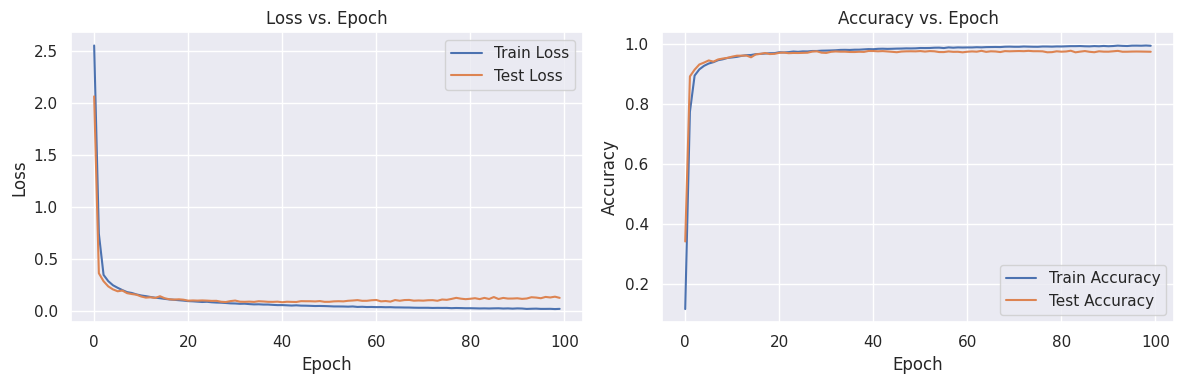

In [15]:
# plot

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the losses
ax1.plot(train_losses, label='Train Loss')
ax1.plot(test_losses, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs. Epoch')
ax1.legend()

# Plot the accuracies
ax2.plot(train_accs, label='Train Accuracy')
ax2.plot(test_accs, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy vs. Epoch')
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()